In [1]:
##### Step 1: import functions #####
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input
from keras.layers import MaxPooling2D, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(1994)
import random
import matplotlib.pyplot as plt
import seaborn as sns
import keras as keras
keras.utils.set_random_seed(111)
from sklearn.metrics import roc_curve, auc
from six import StringIO 
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
from keras.regularizers import L1L2
import os

In [2]:
os.chdir('/Users/elijahwillie/Documents/PhD/DeepLearning_CyTOF/DeepLearningCyTOF/')

In [3]:
# ! wget https://figshare.com/ndownloader/files/38918480 -P ./Data
        
#load data
allData = pd.compat.pickle_compat.load(open( "deep_learning_allData.obj", "rb" ) )
metaData = allData["metaData"]
cytoData = allData["cytoData"]
markerNames = allData["markerNames"]

# inspect the data
print("\nFirst 5 rows of metaData: ")
print(metaData.head(),"\n")

print("Dimensions of cytoData: ",cytoData.shape,"\n")
print("Names of the 27 makers: \n",markerNames.values)


First 5 rows of metaData: 
                                                 name study_accession  CMV_Ab
0   011514-Mike-Study 21-2011-plate 1-2100101_cell...          SDY113    True
1   011514-Mike-Study 21-2011-plate 1-2100201_cell...          SDY113    True
3   011514-Mike-Study 21-2011-plate 1-2100501_cell...          SDY113    True
6   011514-Mike-Study 21-2011-plate 1-2100901_cell...          SDY113   False
19  011514-Mike-Study 21-2011-plate 1-2102501_cell...          SDY113   False 

Dimensions of cytoData:  (472, 10000, 27, 1) 

Names of the 27 makers: 
 ['VIABILITY' 'TCRGD' 'IGD' 'HLADR' 'DNA2' 'DNA1' 'CELL_LENGTH' 'CD94'
 'CD85J' 'CD8' 'CD56' 'CD45RA' 'CD4' 'CD38' 'CD33' 'CD3' 'CD28' 'CD27'
 'CD25' 'CD24' 'CD20' 'CD19' 'CD161' 'CD16' 'CD14' 'CD127' 'CCR7']


In [4]:
y = metaData.CMV_Ab.values
x = cytoData

train_id = (metaData.study_accession.isin(["SDY515","SDY519"])==False)
valid_id = metaData.study_accession=="SDY515"
test_id = metaData.study_accession =="SDY519"

x_train = x[train_id]; y_train = y[train_id]
x_valid = x[valid_id]; y_valid = y[valid_id]
x_test = x[test_id]; y_test = y[test_id]

2/2 [==============================] - 0s 12ms/step


2024-12-12 13:32:24.057617: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


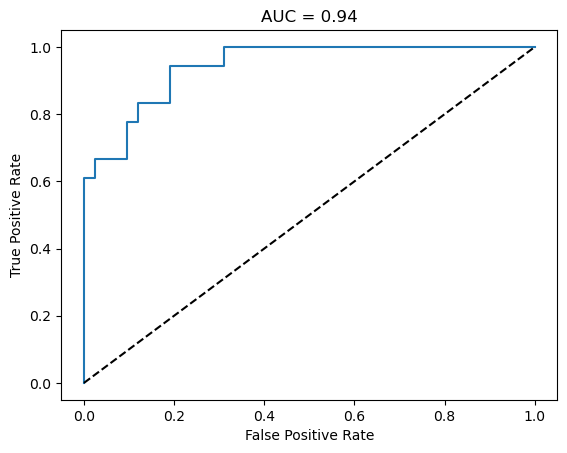

In [11]:
##### Step 7: test the final model #####

# load final model
final_model = load_model('Result/saved_weights.hdf5')

# generate ROC and AUC
y_scores = final_model.predict([x_test])
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = {0:.2f}'.format(roc_auc))
plt.show()

In [12]:
y_scores = pd.DataFrame(np.column_stack([list(y_test), list(y_scores.flatten())]), columns=['truth', 'pred'])
y_scores.to_csv('cmv_deep_cytof_aucs.csv', sep=',')

# Fit Cell CNN

In [10]:
##### define model #####
coeff_l1 = 0
coeff_l2 = 1e-4
model_input = Input(shape=x_train[0].shape)
model_output = Conv2D(5, kernel_size=(1, x_train.shape[2]),
                 activation='linear', 
                      kernel_regularizer=L1L2(l1=coeff_l1, l2=coeff_l2))(model_input)
model_output = Activation("relu")(model_output)

model_output = MaxPooling2D(pool_size=(10000, 1))(model_output)
model_output = Flatten()(model_output)

model_output = Dense(1, activation=None, kernel_regularizer=L1L2(l1=coeff_l1, l2=coeff_l2))(model_output)
model_output = Activation("sigmoid")(model_output)

model = Model(inputs=[model_input],
                           outputs=model_output)
model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='Result/cell_cnn_saved_weights.hdf5', monitor='val_loss', 
                                               verbose=1, save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=100, mode='auto')

/opt/anaconda3/envs/CyTOF_DL/lib/python3.11/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
model.fit([x_train], y_train,
          batch_size=60,
          epochs=200,
          verbose=1,
          callbacks=[checkpointer,earlyStop],
          validation_data=([x_valid], y_valid))

Epoch 1/200
4/6 [===================>..........] - ETA: 0s - loss: 0.8423 - accuracy: 0.5042
Epoch 1: val_loss improved from inf to 0.72209, saving model to Result/cell_cnn_saved_weights.hdf5
6/6 [==============================] - 1s 45ms/step - loss: 0.8215 - accuracy: 0.4985 - val_loss: 0.7221 - val_accuracy: 0.4430
Epoch 2/200
4/6 [===================>..........] - ETA: 0s - loss: 0.7540 - accuracy: 0.5083
Epoch 2: val_loss improved from 0.72209 to 0.71971, saving model to Result/cell_cnn_saved_weights.hdf5
6/6 [==============================] - 0s 26ms/step - loss: 0.7516 - accuracy: 0.4955 - val_loss: 0.7197 - val_accuracy: 0.4430
Epoch 3/200
4/6 [===================>..........] - ETA: 0s - loss: 0.7277 - accuracy: 0.4792
Epoch 3: val_loss improved from 0.71971 to 0.71491, saving model to Result/cell_cnn_saved_weights.hdf5
6/6 [==============================] - 0s 24ms/step - loss: 0.7275 - accuracy: 0.4925 - val_loss: 0.7149 - val_accuracy: 0.5190
Epoch 4/200
4/6 [===============

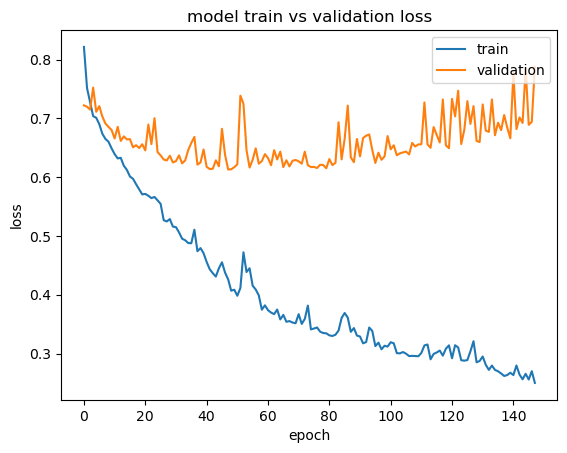

In [12]:
# plot train and validation loss
#model.save('result_11_weights.hdf5')

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [13]:
best_model = load_model('Result/cell_cnn_saved_weights.hdf5')

# print result of the best model
score = best_model.evaluate([x_train], y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

# score = best_model.evaluate([x_valid], y_valid, verbose=0)
# print('Valid loss:', score[0])
# print('Valid accuracy:', score[1])

score = best_model.evaluate([x_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.40417325496673584
Train accuracy: 0.8498498201370239
Test loss: 0.6674861311912537
Test accuracy: 0.550000011920929


2/2 [==============================] - 0s 5ms/step


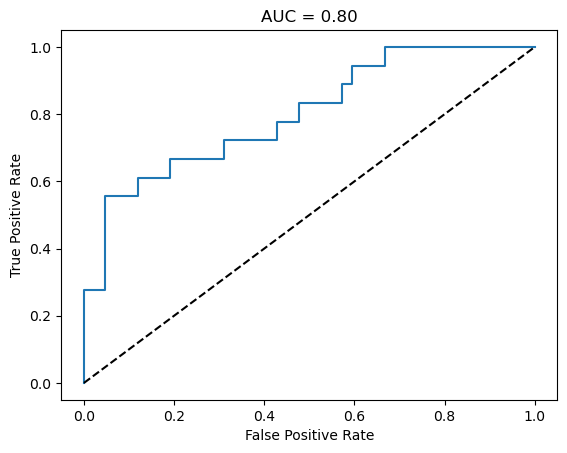

In [14]:
# generate ROC and AUC
y_scores = best_model.predict([x_test])
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = {0:.2f}'.format(roc_auc))
plt.show()

In [15]:
y_scores = pd.DataFrame(np.column_stack([list(y_test), list(y_scores.flatten())]), columns=['truth', 'pred'])
y_scores.to_csv('cmv_cell_cnn_aucs.csv', sep=',')